In [3]:
from ZhilianDataPreprocess import ZhilianDataPreprocess
from LiepinDataPreprocess import LiepinDataPreprocess
from TokChinese import TokChinese
import pandas as pd
import numpy as np
import re

In [4]:
zhilian1 = pd.read_csv('./data/jobInfo_2018_06_30.csv')

zhilian2 = pd.read_json('./data/jobInfo_2018_08_04.json')

liepin = pd.read_csv('./data/jobInfo_liepin.csv')

In [5]:
zl = ZhilianDataPreprocess()

lp = LiepinDataPreprocess()

zl1 = zl.data_process(zhilian1)

zl2 = zl.data_process(zhilian2)

zhilian = pd.concat([zl1,zl2])

liepin = lp.data_process(liepin)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.303 seconds.
DEBUG:jieba:Loading model cost 1.303 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


In [9]:
all_data = pd.concat([zhilian,liepin])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [10]:
all_data.shape

(63014, 21)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63014 entries, 0 to 11337
Data columns (total 21 columns):
company_industry     62903 non-null object
company_name         63007 non-null object
company_nature       51672 non-null object
company_scale        63014 non-null object
demand_number        51676 non-null float64
education_degree     63006 non-null object
jobDescriptionSeg    11338 non-null object
job_description      11338 non-null object
job_experience       63014 non-null object
job_name             63007 non-null object
job_nature           51669 non-null object
publish_date         63014 non-null object
publish_time         51676 non-null object
salary_avg           63014 non-null float64
salary_max           63014 non-null int64
salary_min           63014 non-null int64
skillseg             11338 non-null object
welfare              62792 non-null object
welfareSeg           62792 non-null object
work_district        11338 non-null object
work_position        63007 non-

# 数据处理的类

In [47]:
'''在使用ZhilianDataPreprocess和LiepinDataPreprocess两个
类分别处理完数据之后，将数据汇总然后调用该类，完成数据分析工作。
'''
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud,ImageColorGenerator # 词云包
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

class DataAnalysis:
    def __init__(self):
        pass
    def functionDescription(self):
        print('introduction about each function:')
        print('salaryIntervalAmountAndProportion:将薪资按照区间分段，输出每个区间段内的人员数量和比例。')
        print('educationAmountAndProportionAndSalary:输出不同学历求值人员的数量、比例及平均薪资')
        print('eduAndJobexperienceAndSalary:不同学历不同工作经验对应的平均薪资')
        print('jobCategoryAmountAndProportion:不同工作类别的人员数量及比例')
        print('jobCategoryAndJobexperienceAndSalary:不同工作类别不同工作经验对应的平均薪资')
        print('jobExperienceAndAmountAndProportion:不同工作经验的人员数量及比例')
        print('workPositionAndAmount:不同地点的求职人员数量')
        print('workPositionAndJobfenleiAndSalary:不同地点不同工作种类的平均薪资')
        print('workPositionAndSalary:不同地点的平均薪资')
        print('companyindustryAndAmount:不同行业的求职人员数量')
        print('jobDescriptionAnalysis:统计职位描述中的词语出现频数')
        print('jobDescriptionWordCloud:绘制词云')
        print('jobCategoryAndSalary:统计每种工作的薪资')
    def salaryIntervalAmountAndProportion(self,df):
        df1 = pd.DataFrame()
        df1['salary_avg_cut'] = pd.cut(df['salary_avg'],bins = [0,50000,100000,150000,200000,300000,500000,2200000])                             
        tm1 = df1['salary_avg_cut'].value_counts().to_frame().reset_index()
        tm1.columns = ['薪资区间','人员数量']
        tm2 = df1['salary_avg_cut'].value_counts(normalize = True).to_frame().reset_index()
        tm2.columns = ['薪资区间','数量占比']
        tm3 = tm1.merge(tm2,how = 'inner',on = '薪资区间')
        return tm3
    def educationAmountAndProportionAndSalary(self,df):
        edu1 = df['education_degree'].value_counts().to_frame().reset_index()
        edu1.columns = ['学历','人员数量']
        edu2 = df['education_degree'].value_counts(normalize = True).to_frame().reset_index()
        edu2.columns = ['学历','数量占比']
        edu3 = df.groupby('education_degree')[['salary_avg']].mean().sort_values('salary_avg',ascending = False).applymap(lambda x:int(x)).reset_index()
        edu3.columns = ['学历','平均薪资']
        edu4 = edu1.merge(edu2,how = 'inner',on = '学历').merge(edu3,how = 'inner',on = '学历')
        return edu4
    def eduAndJobexperienceAndSalary(self,df):
        result = df.groupby(['education_degree','job_experience'])[['salary_avg']].mean().applymap(lambda x:int(x)).unstack()
        return result
    def __jobname_fenlei(self,x):
        if  (x is not np.nan) and (x is not None):
            leibie = ['测试','开发','产品','前端','算法','数据','后端','运维','UI','研发','维护','数据库','运营','软件','机器学习','网络']
            i = 0
            for item in leibie:
                if item in x:
                    return item
                    i = 1
                    break
            if i == 0:
                return np.nan
        else:
            return np.nan
    def jobCategoryAmountAndProportion(self,df):
        df['jobname_fenlei'] = df['job_name'].apply(self.__jobname_fenlei)
        df.loc[df['jobname_fenlei'] == '维护','jobname_fenlei'] = '运维'
        df.loc[df['jobname_fenlei'] == '研发','jobname_fenlei'] = '开发'
        job1 = df['jobname_fenlei'].value_counts().to_frame().reset_index()
        job1.columns = ['职位','人员数量']

        job2 = df['jobname_fenlei'].value_counts(normalize = True).to_frame().reset_index()
        job2.columns = ['职位','人员比例']

        job3 = job1.merge(job2,how = 'inner',on = '职位')
        return job3
    def jobCategoryAndJobexperienceAndSalary(self,df):
        df1 = df[pd.notnull(df['jobname_fenlei'])]
        result = df1.groupby([df1['jobname_fenlei'],df1['job_experience']])[['salary_avg']].mean().applymap(lambda x :int(x)if x is not np.nan else -1).unstack()
        return result
    def jobExperienceAndAmountAndProportion(self,df):
        tm1 = df['job_experience'].value_counts().to_frame().reset_index()
        tm1.columns = ['工作经验','人员数量']

        tm2 = df['job_experience'].value_counts(normalize = True).to_frame().reset_index()
        tm2.columns = ['工作经验','人员比例']

        tmp3 = tm1.merge(tm2,how = 'inner',on = '工作经验')
        return tmp3
    def workPositionAndAmount(self,df):
        tmp4 = df.groupby('work_position')[['job_name']].count().sort_values('job_name',ascending = False).reset_index()
        tmp4.columns = ['工作地点','人员数量']
        return tmp4
    def workPositionAndJobfenleiAndSalary(self,df):
        tm5 = df.groupby(['work_position','jobname_fenlei'])[['salary_avg']].mean().applymap(lambda x :int(x)).unstack()
        return tm5
    def workPositionAndSalary(self,df):
        tmp6 = df.groupby('work_position')[['salary_avg']].mean().sort_values('salary_avg',ascending = False).applymap(lambda x: int(x))
        tmp6.reset_index(inplace = True)
        tmp6.columns = ['工作地点','平均工资']
        return tmp6
    def companyindustryAndAmount(self,df):
        tmp7 = df.groupby('company_industry')[['job_name']].count().sort_values('job_name',ascending = False)
        tmp7.reset_index(inplace = True)
        tmp7.columns = ['公司行业','人员数量']
        return tmp7
    def jobDescriptionAnalysis(self,df):
        tmp8 = df[pd.notnull(df['job_description'])] [['job_description','jobDescriptionSeg']]
        tmp8.index = np.arange(0,len(tmp8))
#         tmp8['new_job_description'] = tmp8['jobDescriptionSeg'].apply(lambda x : x[2:-2].split("', '"))
        all_words = []
        for i in tmp8.index:
            all_words.extend(tmp8.loc[i,'jobDescriptionSeg'])
        words_df = pd.DataFrame({'all_words':all_words})   
        words_stat = words_df.groupby(by=['all_words'])['all_words'].agg({"计数":np.size})
        words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False)
        words_stat.drop([words_stat.loc[(words_stat['all_words'] == ' '),:].index[0],words_stat.loc[words_stat['all_words'] == '\r\n'].index[0], words_stat.loc[words_stat['all_words'] == '\n'].index[0]],inplace= True)
        return words_stat
    def jobDescriptionWordCloud(self,df):
        word_stat = self.jobDescriptionAnalysis(df)
        mpl.rc('figure', figsize = (14, 7))
        mpl.rc('font', size = 14)
        mpl.rc('axes', grid = False)
        mpl.rc('axes', facecolor = 'white')
        wordcloud = WordCloud(font_path="simheittf.ttf"
                      ,background_color="white"
                      ,max_font_size=80)
        word_frequence={x[0]:x[1] for x in word_stat.head(1000).values}
        wordcloud=wordcloud.fit_words(word_frequence)
        plt.imshow(wordcloud)
    def jobCategoryAndSalary(self,df):
        df['jobname_fenlei'] = df['job_name'].apply(self.__jobname_fenlei)
        tmp8 = df.groupby('jobname_fenlei')[['salary_avg']].mean().applymap(lambda x :int(x))
        tmp8.reset_index(inplace = True)
        tmp8.columns = ['职位类别','平均薪资']
        return tmp8
        
        

In [48]:
da = DataAnalysis()

In [83]:
b = da.jobCategoryAndSalary(all_data)
b

,职位类别,平均薪资
0,UI,101671
1,产品,213031
2,前端,175952
3,后端,274642
4,开发,172894
5,数据,168020
6,机器学习,268368
7,测试,130667
8,研发,210280
9,算法,293877


In [14]:
c = da.jobDescriptionAnalysis(all_data)
c

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:111: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


,all_words,计数
4,,11338
3,\r\n,11337
1,\n,11322
24001,经验,10221
19642,数据,9850
24423,职责,9316
17090,工作,9253
24524,能力,8956
22799,相关,8897
13278,分析,8689


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:111: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


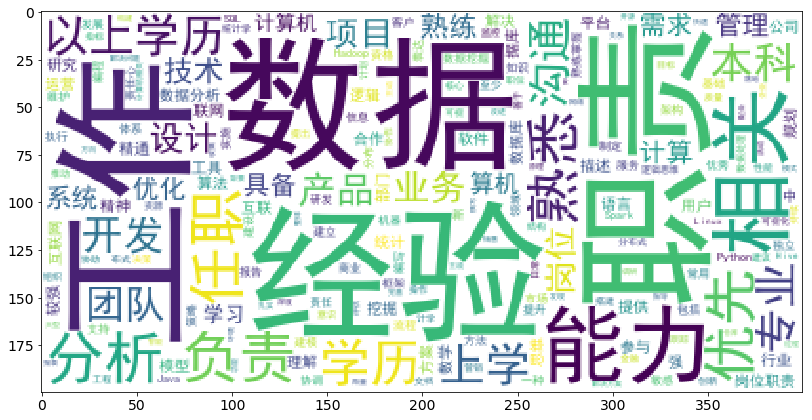

In [46]:
da.jobDescriptionWordCloud(all_data)

In [43]:
salary = da.salaryIntervalAmountAndProportion(all_data)
salary

,薪资区间,人员数量,数量占比
0,"(100000, 150000]",19015,0.321879
1,"(50000, 100000]",16906,0.286179
2,"(150000, 200000]",8566,0.145002
3,"(200000, 300000]",7614,0.128887
4,"(300000, 500000]",3742,0.063343
5,"(0, 50000]",2226,0.037681
6,"(500000, 2200000]",1006,0.017029


In [44]:
edu = da.educationAmountAndProportionAndSalary(all_data)
edu

,学历,人员数量,数量占比,平均薪资
0,本科,25651,0.407120,184936
1,大专,25376,0.402755,119862
2,不限,7349,0.116640,124442
3,中专,3100,0.049202,84877
4,硕士,1037,0.016459,252364
5,中技,311,0.004936,94054
6,高中,104,0.001651,93264
7,博士,78,0.001238,224712


In [45]:
edu_expe_sala = da.eduAndJobexperienceAndSalary(all_data)
edu_expe_sala

salary_avg                                                  
job_experience            1       1-3        10       3-5      5-10        不限
education_degree                                                             
不限                  92148.0  143196.0  350316.0  194638.0  264618.0  112886.0
中专                  80954.0   94017.0       NaN  126561.0  135005.0   83244.0
中技                 106244.0   93883.0       NaN  150877.0       NaN   91324.0
博士                 187507.0  240526.0       NaN  284999.0  387504.0  205246.0
大专                  90587.0  121995.0  302224.0  181830.0  252863.0   96874.0
本科                 107904.0  155935.0  422465.0  215256.0  289432.0  126077.0
硕士                 130504.0  217041.0  539065.0  316367.0  420843.0  202506.0
高中                 130503.0   85631.0       NaN   75007.0   22503.0   91302.0

In [54]:
job_leibie = da.jobCategoryAmountAndProportion(all_data)
job_leibie

,职位,人员数量,人员比例
0,开发,5160,0.199714
1,测试,4858,0.188025
2,数据,4160,0.161009
3,运维,2560,0.099083
4,网络,2518,0.097457
5,产品,2316,0.089639
6,软件,2239,0.086659
7,算法,833,0.032241
8,运营,763,0.029531
9,UI,258,0.009986


In [57]:
tmp1 = da.jobCategoryAndJobexperienceAndSalary(all_data)

In [58]:
tmp1

salary_avg                                                   
job_experience          1       1-3         10       3-5      5-10        不限
jobname_fenlei                                                              
UI                63755.0  143094.0        NaN  148801.0  236249.0   83143.0
产品               128523.0  175516.0   609380.0  248037.0  335516.0  157843.0
前端                    NaN  155108.0    80000.0  267499.0       NaN  164999.0
后端                    NaN  232222.0        NaN  351000.0       NaN       NaN
开发                77534.0  177943.0   455912.0  226111.0  328129.0  106500.0
数据                95630.0  148702.0   300000.0  230902.0  332415.0  122383.0
机器学习                  NaN  269333.0        NaN  302691.0       NaN  245454.0
测试                90253.0  141910.0   562500.0  189747.0  255881.0   94684.0
算法                    NaN  242813.0  1192503.0  427148.0  500642.0  253617.0
网络                83732.0  116848.0   135007.0  174732.0  224824.0   93363.0
软件                84170.0  171855.0   546876.0  226902.0  300344.0  116917.0
运维                91753.0  120641.0   195002.0  182350.0  255830.0   94157.0
运营                97500.0  129080.0   155000.0  168629.0  181488.0   91122.0

In [61]:
tmp2 = da.jobExperienceAndAmountAndProportion(all_data)
tmp2

,工作经验,人员数量,人员比例
0,不限,25869,0.410528
1,1-3,20428,0.324182
2,3-5,11441,0.181563
3,5-10,3778,0.059955
4,1,1247,0.019789
5,10,251,0.003983


In [68]:
tmp3 = da.workPositionAndAmount(all_data)
tmp3

,工作地点,人员数量
0,北京,23042
1,上海,11798
2,深圳,11527
3,广州,7889
4,成都,5597
5,杭州,899
6,天津,376
7,南京,305
8,武汉,199
9,重庆,129


In [71]:
tmp4 = da.workPositionAndJobfenleiAndSalary(all_data)
tmp4

salary_avg                                                    \
jobname_fenlei         UI        产品        前端        后端        开发        数据   
work_position                                                                 
三亚                    NaN       NaN       NaN       NaN       NaN  140000.0   
三门峡                   NaN       NaN       NaN       NaN  105000.0  125000.0   
上海               137271.0  217314.0  255625.0  485000.0  204260.0  172698.0   
东莞                    NaN  220000.0       NaN       NaN  256666.0  103333.0   
中山                    NaN  180000.0       NaN       NaN      -1.0   73333.0   
丹阳                    NaN       NaN       NaN       NaN       NaN   50000.0   
乌鲁木齐                  NaN  125000.0       NaN       NaN  130000.0  170000.0   
乐山                    NaN       NaN       NaN       NaN       NaN   90000.0   
佛山                    NaN  215999.0       NaN       NaN  132499.0  111666.0   
保定                    NaN  215000.0       NaN       NaN       NaN   28749.0   
兰州                    NaN       NaN       NaN       NaN  160000.0  130000.0   
北京               113773.0  231124.0  214599.0  235624.0  220665.0  190115.0   
北海                    NaN       NaN       NaN       NaN       NaN       NaN   
南京                    NaN  192161.0  247500.0  270000.0  144166.0  159175.0   
南宁                    NaN  116666.0       NaN       NaN   95000.0   54999.0   
南昌                    NaN       NaN  101666.0       NaN  133750.0   88999.0   
南通                    NaN       NaN       NaN       NaN   90000.0   50000.0   
厦门                    NaN   76249.0       NaN       NaN  145999.0  109038.0   
台州                    NaN       NaN       NaN       NaN  100000.0       NaN   
合肥                    NaN  132500.0   59999.0       NaN  160263.0  114422.0   
周口                    NaN       NaN       NaN       NaN       NaN       NaN   
呼和浩特                  NaN       NaN       NaN       NaN       NaN       NaN   
哈尔滨                   NaN       NaN       NaN       NaN       NaN  120714.0   
嘉兴                    NaN       NaN       NaN       NaN   72499.0   22499.0   
四川省                   NaN  150000.0       NaN       NaN       NaN       NaN   
大连                    NaN   50000.0       NaN       NaN  129999.0   98333.0   
天津                75007.0  165419.0       NaN       NaN  118149.0   78701.0   
太原                    NaN  110000.0       NaN       NaN  112500.0  105833.0   
威海                    NaN       NaN       NaN       NaN       NaN      -1.0   
宁德                    NaN  110000.0       NaN       NaN       NaN      -1.0   
...                   ...       ...       ...       ...       ...       ...   
肇庆                    NaN       NaN       NaN       NaN       NaN   70000.0   
芜湖                    NaN       NaN       NaN       NaN       NaN  140000.0   
苏州                    NaN  213636.0   89999.0       NaN  172391.0  153374.0   
茂名                    NaN       NaN       NaN       NaN       NaN  110000.0   
荆州                    NaN       NaN       NaN       NaN       NaN  160000.0   
莆田                    NaN       NaN       NaN       NaN       NaN       NaN   
菏泽                    NaN       NaN       NaN       NaN       NaN   50000.0   
衡水                    NaN       NaN       NaN       NaN       NaN       NaN   
衡阳                    NaN       NaN       NaN       NaN       NaN       NaN   
襄阳                    NaN       NaN       NaN       NaN       NaN       NaN   
西安                    NaN  131428.0       NaN       NaN  132999.0  142608.0   
贵州省                   NaN       NaN       NaN       NaN       NaN  300000.0   
贵阳                    NaN       NaN       NaN       NaN      -1.0  135999.0   
赣州                    NaN       NaN       NaN       NaN       NaN   60000.0   
遵义                    NaN  150000.0       NaN       NaN       NaN       NaN   
邢台                    NaN       NaN       NaN       NaN       NaN   80000.0   
郑州               175000.0  170000.0   85000.0       NaN   97777.0

In [73]:
tmp5 = da.workPositionAndAmount(all_data)
tmp5

,工作地点,人员数量
0,北京,23042
1,上海,11798
2,深圳,11527
3,广州,7889
4,成都,5597
5,杭州,899
6,天津,376
7,南京,305
8,武汉,199
9,重庆,129


In [76]:
tmp6 = da.companyindustryAndAmount(all_data)
tmp6

,公司行业,人员数量
0,计算机软件,14923
1,互联网/电子商务,13066
2,IT服务(系统/数据/维护),10909
3,互联网/移动互联网/电子商务,4499
4,计算机硬件,1999
5,基金/证券/期货/投资,1732
6,专业服务/咨询(财会/法律/人力资源等),1487
7,教育/培训/院校,1279
8,通信/电信运营、增值服务,1176
9,电子技术/半导体/集成电路,1070


In [49]:
a = da.functionDescription()
a

introduction about each function:
salaryIntervalAmountAndProportion:将薪资按照区间分段，输出每个区间段内的人员数量和比例。
educationAmountAndProportionAndSalary:输出不同学历求值人员的数量、比例及平均薪资
eduAndJobexperienceAndSalary:不同学历不同工作经验对应的平均薪资
jobCategoryAmountAndProportion:不同工作类别的人员数量及比例
jobCategoryAndJobexperienceAndSalary:不同工作类别不同工作经验对应的平均薪资
jobExperienceAndAmountAndProportion:不同工作经验的人员数量及比例
workPositionAndAmount:不同地点的求职人员数量
workPositionAndJobfenleiAndSalary:不同地点不同工作种类的平均薪资
workPositionAndSalary:不同地点的平均薪资
companyindustryAndAmount:不同行业的求职人员数量
jobDescriptionAnalysis:统计职位描述中的词语出现频数
jobDescriptionWordCloud:绘制词云
jobCategoryAndSalary:统计每种工作的薪资
